The following section provides specific examples of generative BigSMILES to demonstrate how various polymer ensembles might be created. This is an interactive Jupyter notebook that generates visual representations of polymeric ensembles automatically using the [reference implementation](https://github.com/InnocentBug/bigSMILESgen) of generative BigSMILES. Visual representations of polymers can become complex for long-chain molecules, hence we typically restrict ourselves to a manageable length. 

# Preliminary Code for Visualization

This section includes Python code that converts generative BigSMILES into visual representations suitable for a Jupyter notebook. While not essential for understanding the main text, it can serve as a reference for how to use the reference implementation.

In [1]:
import numpy as np
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
from IPython.display import SVG
import pydot

from rdkit.Chem import rdDepictor
from rdkit.Chem.Draw import rdMolDraw2D

import bigsmiles_gen
from bigsmiles_gen import System, mol_prob, Molecule, System

# Consistent random numbers also across calls
rng = np.random.default_rng(42)


def render_svg(svg):
    """Render SVG images in the Notebook"""
    try:
        svg_string = svg.decode("utf-8")
    except AttributeError:
        svg_string = svg
    svg_string = svg_string.replace("svg:", "")
    return SVG(svg_string)


def moltosvg(mol, molSize=(450, 150), kekulize=True):
    """Generate a SVG stick representation of molecule."""
    mc = Chem.Mol(mol.ToBinary())
    if kekulize:
        try:
            Chem.Kekulize(mc)
        except:
            mc = Chem.Mol(mol.ToBinary())
    if not mc.GetNumConformers():
        rdDepictor.Compute2DCoords(mc)
    drawer = rdMolDraw2D.MolDraw2DSVG(molSize[0], molSize[1])
    drawer.DrawMolecule(mc)
    drawer.FinishDrawing()
    svg = drawer.GetDrawingText()
    return svg


def draw_molecule(molecule_string):
    global rng
    # Generate the abstract python object, parsing bigSMILES
    # Try it as a system first
    bigSMILESmol = System(molecule_string)
    mol = bigSMILESmol.generate(rng=rng)
    return render_svg(moltosvg(mol.get_mol()))


def draw_generation_graph(molecule_string):
    bigSMILESmol = Molecule(molecule_string)
    graph = bigSMILESmol.gen_reaction_graph()
    graph_dot = bigsmiles_gen.reaction_graph_to_dot_string(graph, bigSMILESmol)
    pydot_graph = pydot.graph_from_dot_data(graph_dot)[0]
    graph_svg = pydot_graph.create_svg()
    return render_svg(graph_svg)

# Case Study: PS and PMMA

Polystyrene (PS) and polymethyl methacrylate (PMMA) are two well-known and widely studied polymers. We'll use them as examples to demonstrate different concepts of how generative BigSMILES can be employed to create various ensembles.

To begin with, let's consider the standard BigSMILES notation for PS and PMMA repeat units.

```
CCC(C){[>][<]CC([>])c1ccccc1[<], [>][<]CC([>])C(=O)OC [<]}[Br]
```

In common terms, this represents the random copolymer PS-r-PMMA. Technically, this BigSMILES notation covers all subsequent examples, and we'll show how generative BigSMILES can be used to distinguish between different polymer ensembles.

## PS-r-PMMA with Molecular Weight Distribution

Our first step is to specify the molecular weight distribution. We'll use the Schulz-Zimm distribution as an example, with a molecular weight average (Mw) of 1500 and a number average molecular weight (Mn) of 1400. 


In [2]:
# Define a generative bigSMILES string representing an ensemble of molecules
generative_bigSMILES = (
    "CCC(C){[>][<]CC([>])c1ccccc1, [<]CC([>])C(=O)OC [<]}|schulz_zimm(1500, 1400)|[Br]"
)

/home/ludwig/git/bigSMILESgen/bigsmiles_gen/system.py:70: UserWarning: The system cannot be fully generated, since the total system molecular weight cannot be estimated.
  warn(


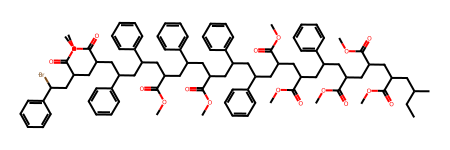

In [3]:
# Visualize the generated molecule
draw_molecule(generative_bigSMILES)

To better understand the composition of our ensemble, let's visualize its generative graph:

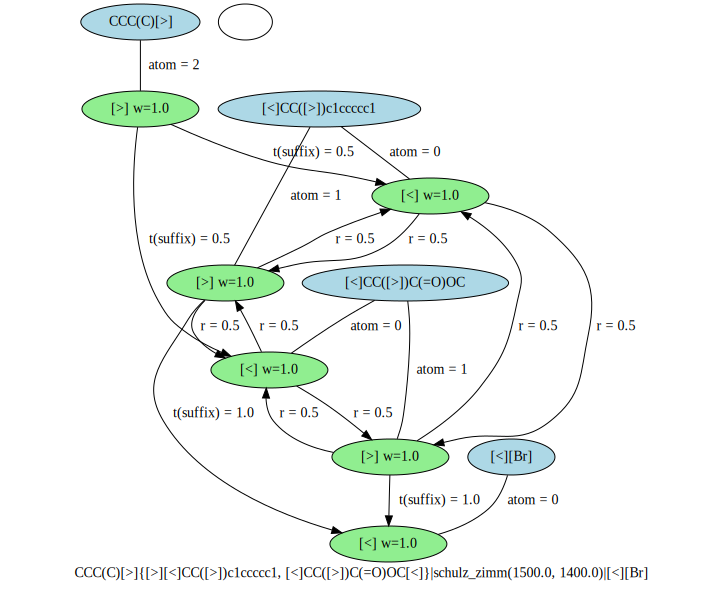

In [4]:
# Draw the generative graph of the ensemble
draw_generation_graph(generative_bigSMILES)

As we can see from both the molecule and its generative graph, Polystyrene (PS) and Poly(methyl methacrylate) (PMMA) are present in equal proportions in this ensemble. Our next step will be to adjust this composition using the bond descriptor weights.

## Creating a PS-r-PMMA ensemble with an 80:20 ratio

We can alter the composition of PS and PMMA by assigning different weights to the bond descriptors.

In [5]:
# Define a generative bigSMILES string with weighted bond descriptors
generative_bigSMILES = (
    "CCC(C){[>][<|8|]CC([>|8|])c1ccccc1, [<|2|]CC([>|2|])C(=O)OC [<]}|schulz_zimm(1500, 1400)|[Br]"
)

/home/ludwig/git/bigSMILESgen/bigsmiles_gen/system.py:70: UserWarning: The system cannot be fully generated, since the total system molecular weight cannot be estimated.
  warn(


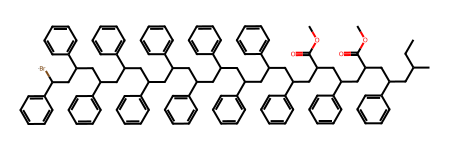

In [6]:
# Visualize the new generated molecule
draw_molecule(generative_bigSMILES)

The changes are noticeable, with PS now being the majority monomer and PMMA reduced to a minority. The generative graph will reflect this change, particularly in the transition rates `r` between bond descriptors for the two monomers.

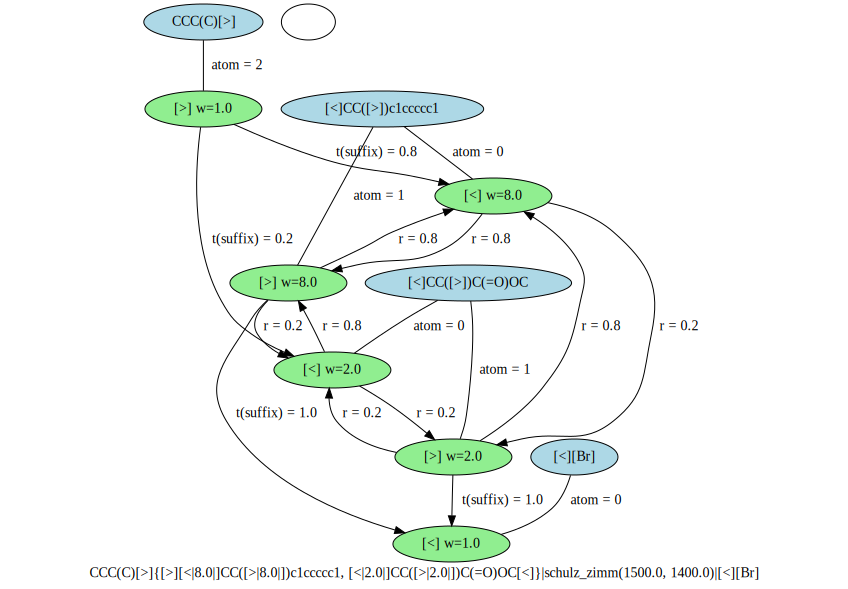

In [7]:
# Draw the generative graph for the modified ensemble
draw_generation_graph(generative_bigSMILES)

## Modifying PS-r-PMMA blockiness to 70% with a 50:50 ratio

In the previous example, we adjusted the ratio of PS to PMMA but didn't specify the blockiness, or the likelihood that a given monomer is followed by the same type. By using list weight notation in our generative bigSMILES string, we can set the transition probabilities for PS to PS and PMMA to PMMA. 

For instance, let's set the transition probability for both PS -> PS and PMMA -> PMMA to 70%, yielding a noticeably blockier random copolymer. We can accomplish this by assigning weights of 7 and 3 to the respective transitions between the monomers.

In [8]:
# Define a generative bigSMILES string with adjusted blockiness
generative_bigSMILES = "CCC(C){[>][<|0 7 0 3|]CC([>|7 0 3 0|])c1ccccc1, [<|0 3 0 7|]CC([>|3 0 7 0|])C(=O)OC [<]}|schulz_zimm(2500, 2400)|[Br]"

/home/ludwig/git/bigSMILESgen/bigsmiles_gen/system.py:70: UserWarning: The system cannot be fully generated, since the total system molecular weight cannot be estimated.
  warn(


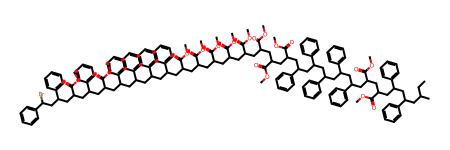

In [9]:
# Visualize the blockier molecule
draw_molecule(generative_bigSMILES)

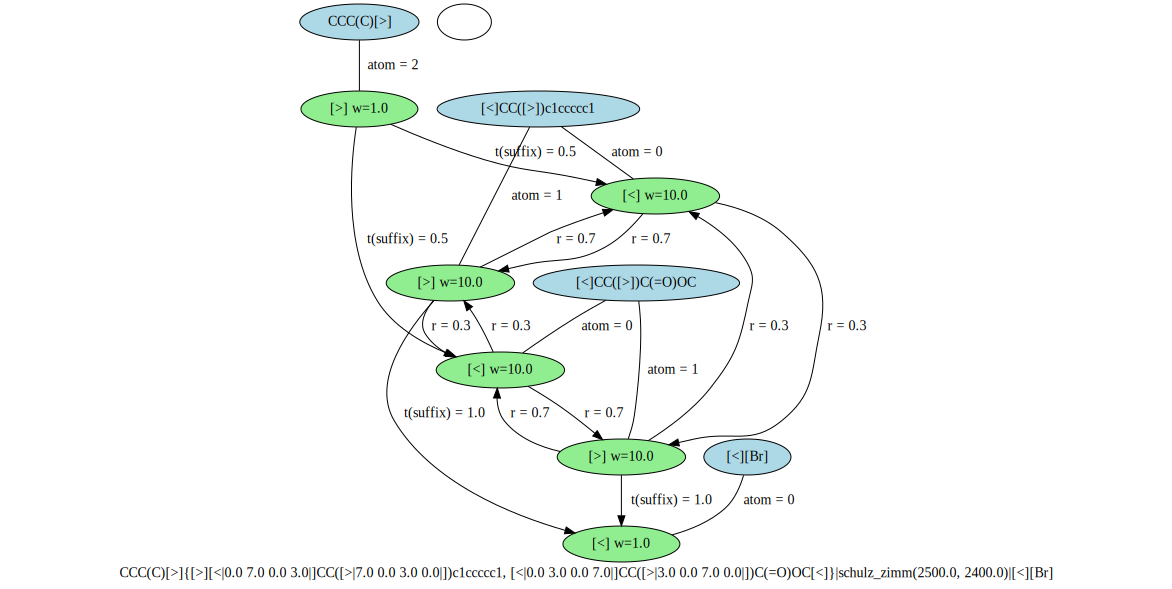

In [10]:
# Draw the generative graph for the blockier ensemble
draw_generation_graph(generative_bigSMILES)

From the generative graph, you can see how the transition probabilities now favor remaining within the same block rather than switching to a new one.

## PS-r-PMMA with 70% blockiness for PS and 20% for PMMA

In the previous example, the transition probability into the other block was 30% for both blocks, resulting in a balanced ratio of 50% between the two monomers. However, we can exert more control over the composition by varying the blockiness of the different blocks.

In this case, we will maintain the 70% blockiness for Polystyrene (PS) but reduce the blockiness of Poly(methyl methacrylate) (PMMA) to 20%.

In [11]:
# Define a generative bigSMILES string with varied blockiness
generative_bigSMILES = "CCC(C){[>][<|0 7 0 3|]CC([>|7 0 3 0|])c1ccccc1, [<|0 8 0 2|]CC([>|8 0 2 0|])C(=O)OC [<]}|schulz_zimm(2500, 2400)|[Br]"

/home/ludwig/git/bigSMILESgen/bigsmiles_gen/system.py:70: UserWarning: The system cannot be fully generated, since the total system molecular weight cannot be estimated.
  warn(


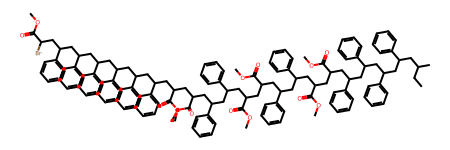

In [12]:
# Visualize the resulting molecule
draw_molecule(generative_bigSMILES)

In the generated molecule, you can see that PS remains blocky, but it is now interspersed with less blocky PMMA monomers. The ratio between the monomers can be estimated by comparing the probabilities to stay within the same block, which yields approximately 0.286.

The generative graph should also accurately represent these transition probabilities.

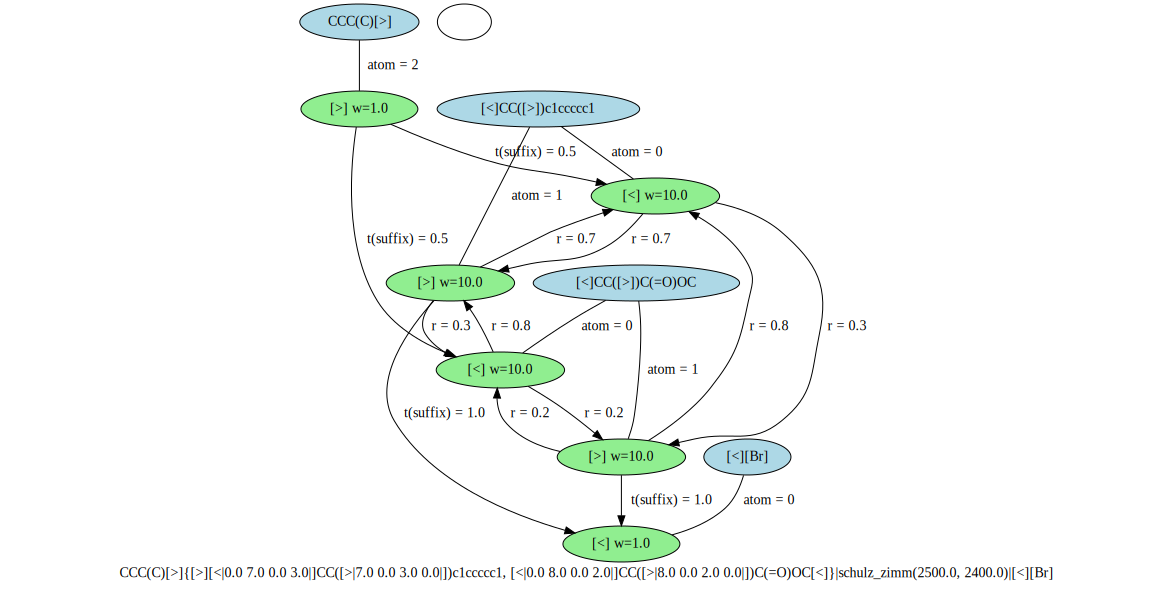

In [13]:
# Draw the generative graph for the modified ensemble
draw_generation_graph(generative_bigSMILES)

## PS-r-PMMA in an alternating sequence (least blocky)

One way to minimize blockiness is by creating an alternating sequence of monomers. This can be represented with identical bond descriptors in the regular BigSMILES notation. For example, the string `CCC(C){[>2][<1]CC([>2])c1ccccc1, [<2]CC([>1])C(=O)OC ; [<1][Br], [<2][Br] []}` specifies that each monomer can only bond with the other monomer type and not with itself, resulting in an alternating sequence.

This limitation is represented by using stochastic end groups with both bond descriptors, as the molecule can end in either PS or PMMA and both need to be terminable. However, this prevents continuation of the molecule after the stochastic object. 

To overcome this limitation in generative BigSMILES, we can use listed bond weights instead. This allows all bond descriptors to be compatible while defining zero transition probabilities for unwanted connections.

In [14]:
# Define a generative bigSMILES string with zero transition probabilities for unwanted connections
generative_bigSMILES = "CCC(C){[>][<|0 0 0 1|]CC([>|0 0 1 0|])c1ccccc1, [<|0 1 0 0|]CC([>|1 0 0 0|])C(=O)OC [<]}|schulz_zimm(1000, 900)|[Br]"

/home/ludwig/git/bigSMILESgen/bigsmiles_gen/system.py:70: UserWarning: The system cannot be fully generated, since the total system molecular weight cannot be estimated.
  warn(


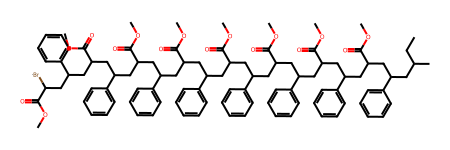

In [15]:
# Visualize the resulting molecule
draw_molecule(generative_bigSMILES)

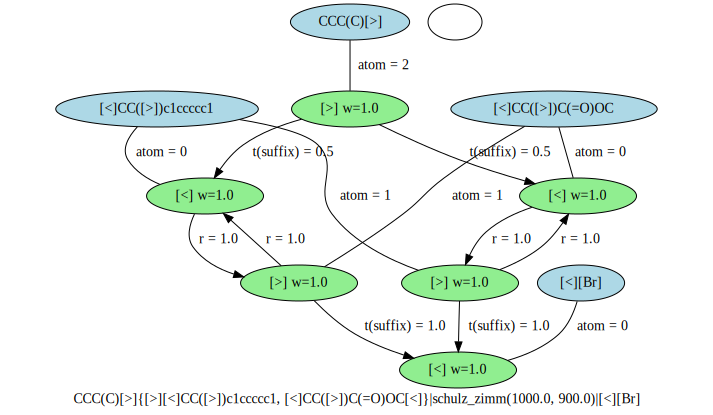

In [16]:
# Draw the generative graph for the alternating ensemble
draw_generation_graph(generative_bigSMILES)

As seen in the generative graph and the generated molecule, the ensemble now follows an alternating sequence. Moreover, the use of listed bond weights allows for potential continuation as it does not require stochastic end groups.

## PS-b-PMMA Diblock Copolymer

At the other end of the spectrum is the diblock copolymer. While the original BigSMILES notation correctly describes diblock copolymers, a more explicit representation employs two connected stochastic objects, as seen in the string `CCC(C){[>][<]CC([>])c1ccccc1 [<]}{[>][<]CC([>])C(=O)OC[<]}[Br]`.

The same notation can be applied within the generative BigSMILES:

In [17]:
# Define a generative bigSMILES string for a diblock copolymer
generative_bigSMILES = "CCC(C){[>][<]CC([>])c1ccccc1 [<]}|schulz_zimm(1000,900)|{[>][<]CC([>])C(=O)OC[<]}|schulz_zimm(1000, 900)|[Br]"

/home/ludwig/git/bigSMILESgen/bigsmiles_gen/system.py:70: UserWarning: The system cannot be fully generated, since the total system molecular weight cannot be estimated.
  warn(


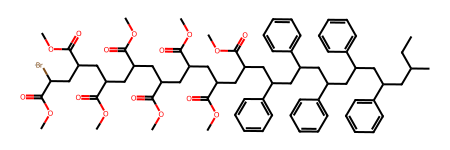

In [18]:
# Visualize the resulting molecule
draw_molecule(generative_bigSMILES)

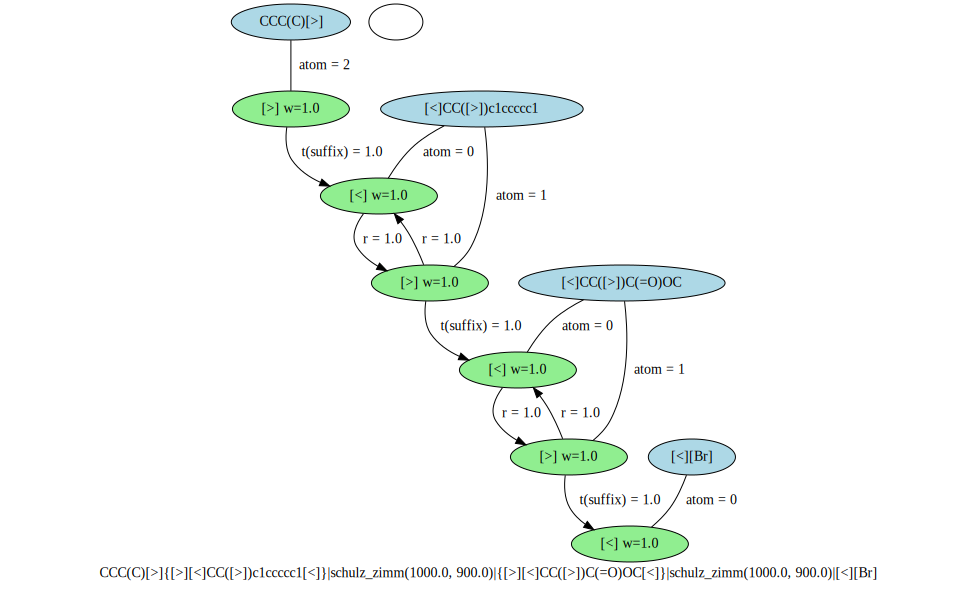

In [19]:
# Draw the generative graph for the diblock copolymer
draw_generation_graph(generative_bigSMILES)

In the BigSMILES notation, the ratio between the two blocks remains unspecified. However, with generative BigSMILES, you can specify the size of the two blocks via the molecular weight specification for each stochastic object.

## PS and PMMA Homopolymer Mixtures

The original BigSMILES notation also encompasses polymer ensembles of PS and PMMA homopolymers, and mixtures of the two, although it's recommended to avoid describing the homopolymers in this way.

There exists a BigSMILES variant that can depict a mixture of PS and PMMA homopolymers:

`{[][<1]CC([>1])c1ccccc1, [<2]CC([>2])C(=O)OC; CC(C)[>1], CC(C)[>2], [<1][Br], [<2][Br][]}`

In this variant, all bond descriptors between PS or PMMA are incompatible, preventing connections between PS and PMMA monomers or end groups. As a result, this notation uniquely identifies a mixture of PS and PMMA homopolymers. However, using this notation to depict a mixture is strongly discouraged.

This characteristic of the notation can be utilized in generative BigSMILES as well:

In [20]:
# Define a generative bigSMILES string for a mixture of PS and PMMA homopolymers
generative_bigSMILES = "{[][<1]CC([>1])c1ccccc1, [<2]CC([>2])C(=O)OC; CC(C)[>1|2|], CC(C)[>2], [<1|2|][Br], [<2][Br][]}|schulz_zimm(700, 600)|"

/home/ludwig/git/bigSMILESgen/bigsmiles_gen/system.py:70: UserWarning: The system cannot be fully generated, since the total system molecular weight cannot be estimated.
  warn(


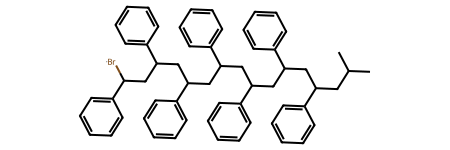

In [21]:
# Visualize the resulting molecules
draw_molecule(generative_bigSMILES)

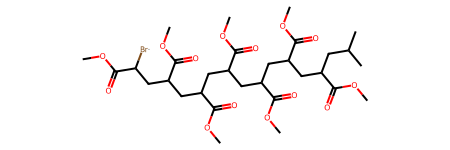

In [22]:
# Visualize the resulting molecules
draw_molecule(generative_bigSMILES)

Note how the various homopolymers are generated from a single BigSMILES string. We've used the weight of the end groups to achieve a 2:1 ratio between PS and PMMA.

The generative graph clearly illustrates how the two types of molecules are separate from one another:

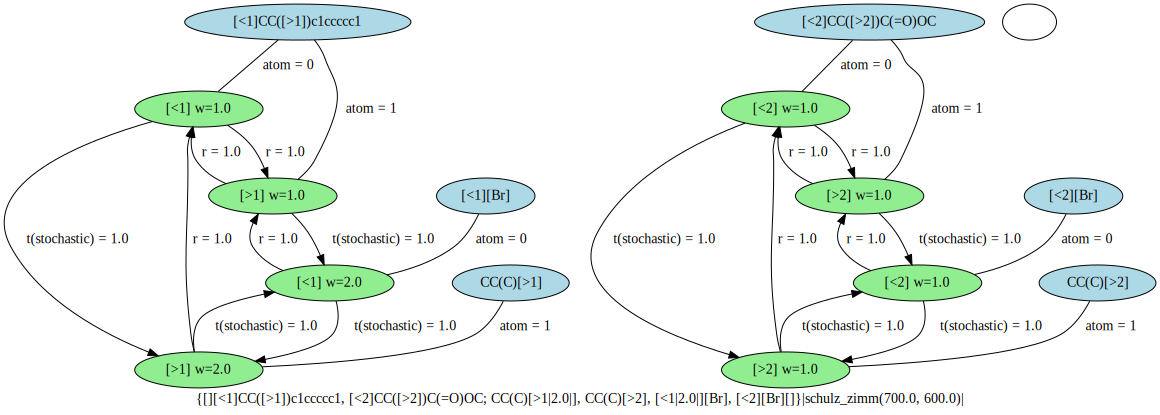

In [23]:
# Draw the generative graph for the mixture of homopolymers
draw_generation_graph(generative_bigSMILES)

Despite this functionality, using this notation

 to describe a mixture of homopolymers remains inadvisable. Instead, use the mixture notation of generative BigSMILES, which offers finer control over the resulting ensembles and more accurately conveys the intent:

In [24]:
# Define a generative bigSMILES string for a more explicit mixture of PS and PMMA homopolymers
generative_bigSMILES = "CC(C){[>][<]CC([>])c1ccccc1 [<]}|schulz_zimm(700, 600)|[Br].|5000|CC(C){[>][<]CC([>])C(=O)OC[<]}|schulz_zimm(700, 600)|[Br].|66%|"

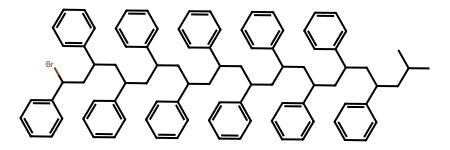

In [25]:
# Visualize the resulting molecules
draw_molecule(generative_bigSMILES)

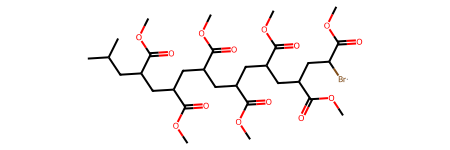

In [26]:
draw_molecule(generative_bigSMILES)

The enhanced notation, strongly recommended for mixtures, leads to the same molecular ensemble but is more straightforward and doesn't necessitate single stochastic object notation for mixtures. 

This applies universally to mixtures such as polymers in solution, even though we're showcasing a mixture of two homopolymers here.

## Homopolymer: AA, BB Nylon 6,6

`[H]O{[>][<]C(=O)CCCCC(=O)[<],[>]NCCCCCCN[>][<]}[H]`

## Endgroups

### Implicit: Realistic Nylon 6,6

`{[][<]C(=O)CCCCC(=O)[<],[>]NCCCCCCN[>];[>]O, [<][H][]}`



### Explicit

`[H]O{[>][<]C(=O)CCCCC(=O)[<],[>]NCCCCCCN[>][<]}[H]`



### Mixed

`CCOC(=O)C(C)(C){[>][<]CC([>])c1ccccc1; [<]Br, [<]H []}`

## Star polymer

A star polymer is generally polymer, that have a center from which several arms are stretched out.
One way of writing down a BigSMILES for a star polymer can be this:
`CC({[$][$]CC[$][$]}[H])({[$][$]CC[$][$]}[H])CCC`

For generative BigSMILES there might be several approaches in realizing star polymers.
In the following sections we discuss them.

### Start with an initial center to grow arms

A general good starting point for generative BigSMILES is the central connection point for the arms.
In this exmples, I am using a 3 arm polymer, so the central connecting element may look like this: `C(C[<])(C[<])(C[<])`.
And the 3 respective arms of the polymer can grow from the 3 `[<]` bond descriptors.

To ensure that the we start the generation with this element, we are using a trick.
We pull one atom of this (here `[H]`) of the initial carbon out of the stochastic element and make it the prefix.
`[H]{[$] [$]C(C[<])(C[<])(C[<]) ...`
Here the `[$]` bond descriptor is the right terminal bond descriptor and only compatible with our initial central element. Here we use the `[$]` for this, but bond descriptors can always be made unique, by assigning them a unique id like so `[$2]`.

#### Equal length arms
After this, we add the growth repeat units for the arms, and add terminal group for the arms to the stochastic element, both are made only compatible with one another and the grow start points.

`[H]{[$] [$]C(C[<])(C[<])(C[<]), [>]CC[<]; [>][H] []}`

Now we just need add a molecular weight distribution.
This molecular weight distribution covers the length of the combined arms as they stochastically grow.
The Gaussian distribution is well suited for this with its linearity, because we can add up the means and variances of the separate arms, and achieve Gaussian distribution for them.
So for example, we desire arms with an Mw of $200$ with a variance of $50$ like so.
Note, that this arm length growth is purely stochastic in this case.

`[H]{[$] [$]C(C[<])(C[<])(C[<]), [>]CC[<]; [>][H] []}|gauss(600, 150)|`


In [27]:
generative_bigSMILES = "[H]{[$] [$]C(C[<])(C[<])(C[<]), [>]CC[<]; [>][H] []}|gauss(600, 150)|"

/home/ludwig/git/bigSMILESgen/bigsmiles_gen/system.py:70: UserWarning: The system cannot be fully generated, since the total system molecular weight cannot be estimated.
  warn(


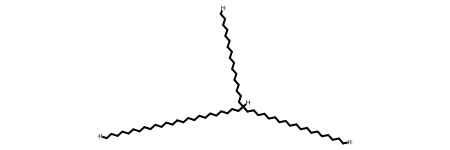

In [28]:
draw_molecule(generative_bigSMILES)

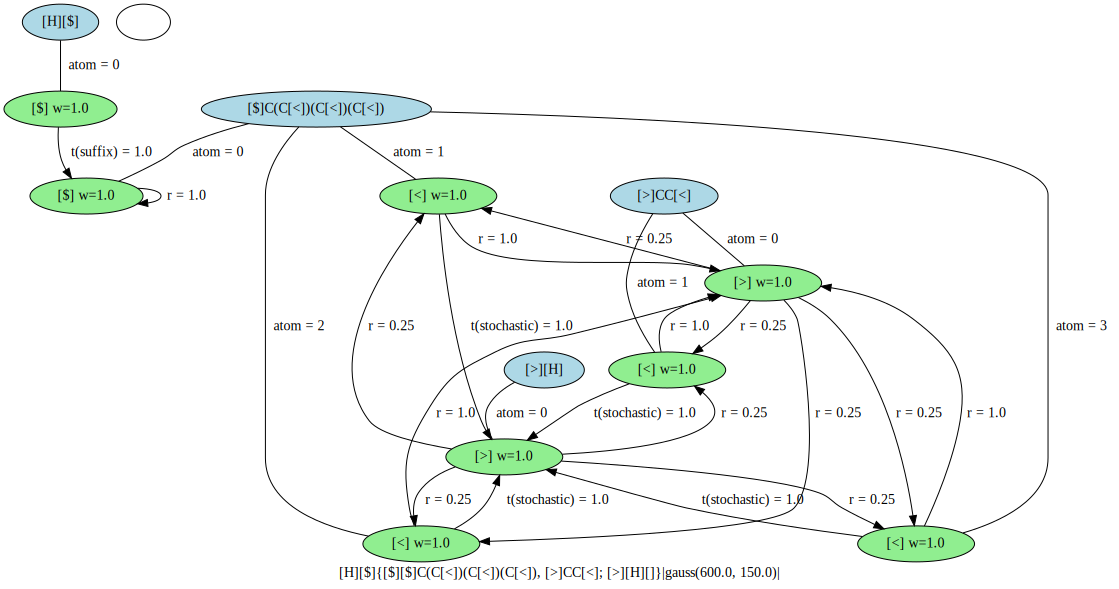

In [29]:
draw_generation_graph(generative_bigSMILES)

#### Non-equal length arms

In case the arms are not of equal length, we can describe this similar to random copolymers, by assigning different growth repeat units different weights.

`[H]{[$] [$]C(C[<])(C[<])(C[<2]), [>]CC[<], [>2]OCO[<2]; [>][H], [>2]O []}|gauss(600, 150)|`

Here we use the thrid attachment point, to attach the separate arm with a different chemistry `[>2]OCO[<2]` and a unique end group for it `[>2]O`.
Note that it is not necessary to have separete chemistry here, just different bond descriptors suffices as well.

We haven't assigned different weight yet.

/home/ludwig/git/bigSMILESgen/bigsmiles_gen/system.py:70: UserWarning: The system cannot be fully generated, since the total system molecular weight cannot be estimated.
  warn(


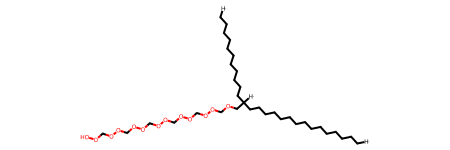

In [30]:
generative_bigSMILES = (
    "[H]{[$] [$]C(C[<])(C[<])(C[<2]), [>]CC[<], [>2]OCO[<2]; [>][H], [>2]O []}|gauss(600, 150)|"
)
draw_molecule(generative_bigSMILES)

Now we can assign this special arm different weights, to make it shorter or longer with respect to the other arms. Here we increase the weight from the default `|1|` to `|2|`, making it twice more likely to grow the second arm.

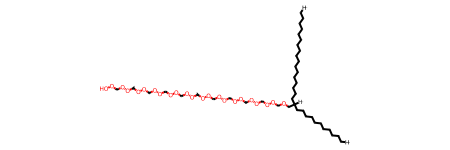

In [31]:
generative_bigSMILES = "[H]{[$] [$]C(C[<])(C[<])(C[<2|2|]), [>]CC[<], [>2|2|]OCO[<2|2|]; [>][H], [>2]O []}|gauss(800, 200)|"
draw_molecule(generative_bigSMILES)

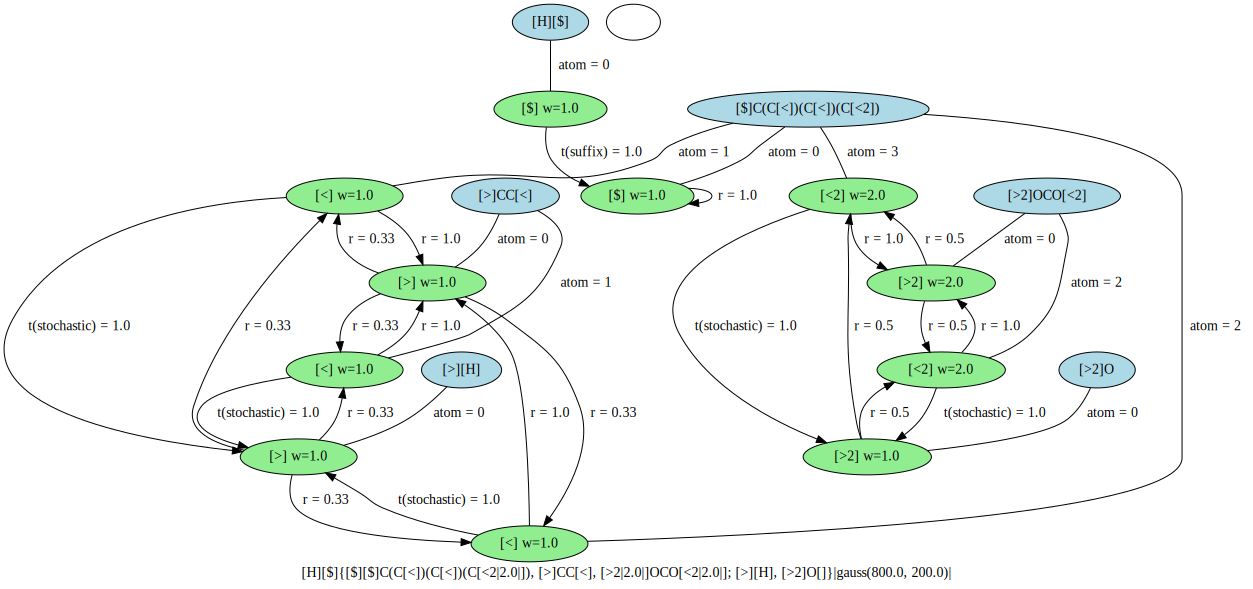

In [32]:
draw_generation_graph(generative_bigSMILES)

## Ring polymer

A stochastic ring polymer can be described in BigSMILES with connection notation `1` in SMILES across a stochastic object, like so: `C1{[>][<]CCO[>][<]}CO1`

In this case, the first carbon atom and the last oxygan atom close the ring with a covalent connection as both are decorated with `1`.

This can be exactly mimicked in generative bigSMILES as well: `C1{[>][<]CCO[>][<]}|poisson(1000)|CO1`

However, the current reference implemenation does not support the connection across a stochastic object.

*Note*:
The reasion behind this lack of support is, that every SMILES token has to be a valid SMILES string for a molecule.
In this case, neither the prefix `C1` nor the suffix `CO1` are valid SMILES strings that can generate a molecule.

@Dylan, do you want to add your implemenation here, as one that can handle this situation?

## Branched polymer: low density poly-ethylene

The BigSMILES for branched poly-ethylene can be specified as: `C{[$][$]CC([$])[$],[$]CC[$]; [$][H][$]}[H]`

With generative BigSMILES we obtain a higher degree of control.
First, we add a molecular weight distribution: here Flory-Schulz


/home/ludwig/git/bigSMILESgen/bigsmiles_gen/system.py:70: UserWarning: The system cannot be fully generated, since the total system molecular weight cannot be estimated.
  warn(


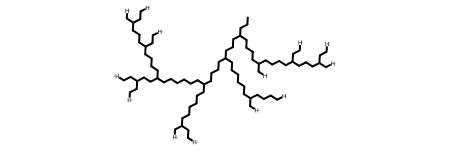

In [33]:
generative_bigSMILES = "C{[$][$]CC(CC[$])(CC[$]),[$]CC[$]; [$][H][$]}|flory_schulz(1e-3)|[H]"
draw_molecule(generative_bigSMILES)

But we can also control the the branch point density stochastically via weights of the bond descriptors.
In this example, we are assigning 1/10 the weight for all bond descriptors in a branch point repeat unit. The resulting transition probabilities can be read from the generation graph.

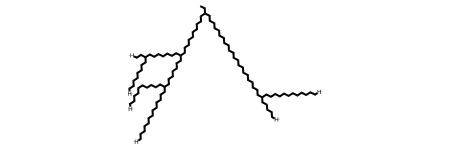

In [34]:
generative_bigSMILES = (
    "C{[$][$|.1|]CC(CC[$|.1|])(CC[$|.1|]),[$]CC[$]; [$][H][$]}|flory_schulz(1e-3)|[H]"
)
draw_molecule(generative_bigSMILES)

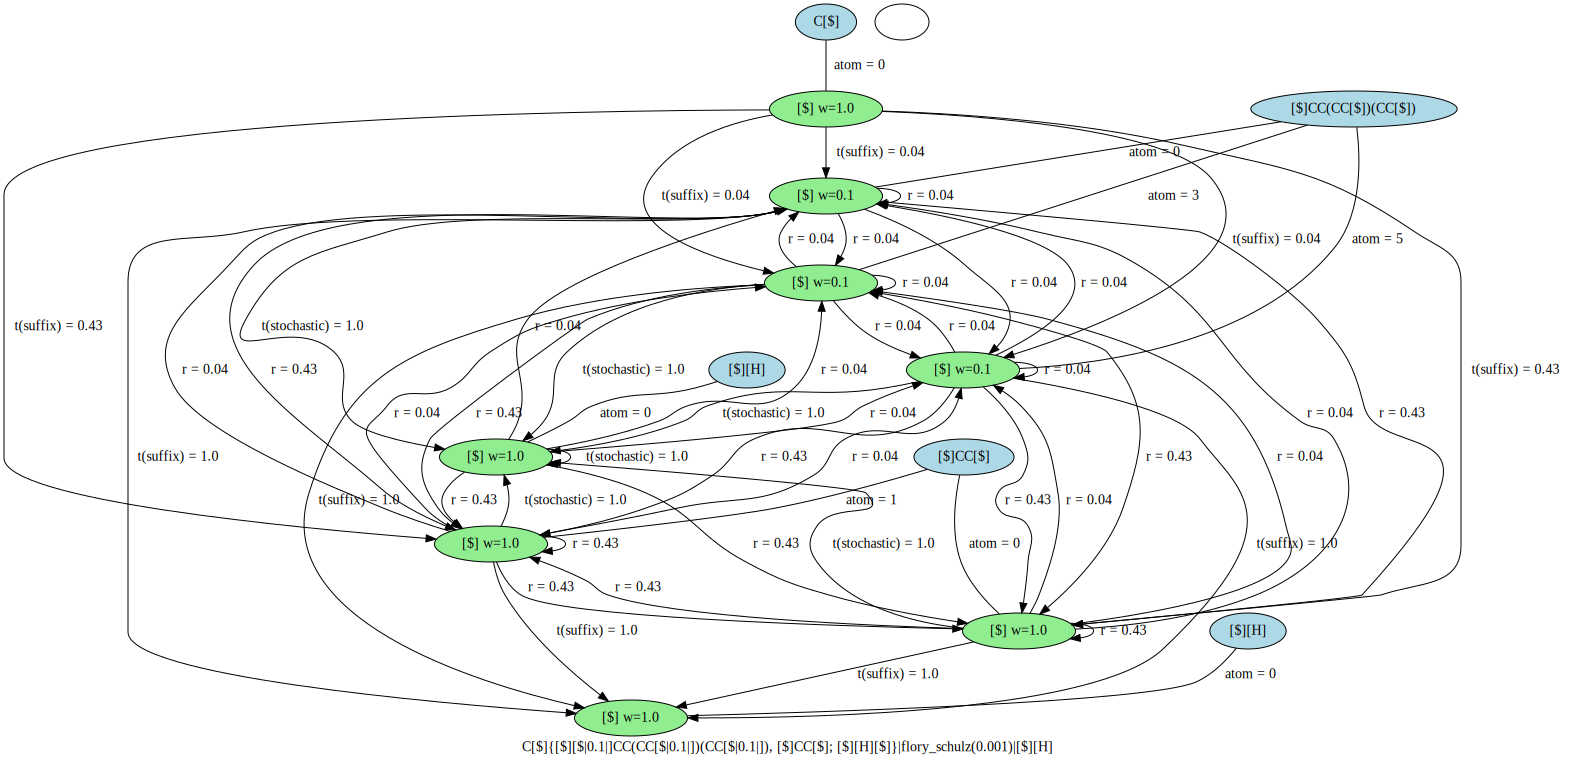

In [35]:
draw_generation_graph(generative_bigSMILES)

## Internal loops possible: hyper-branched Poly(ethylene)

@ Dylan, can you explain, what you mean by "internal loops possible"?

I can generate the BigSMILES with generative BigSMILES, but it won't do internal loops like cross-links.
That is something, I do not support at the moment (in the notation), but maybe we have to add it?
For cross-linked systems and this.

The reason, I didn't support it so far, is that this depends on the spatial proximity between reacting units, something we cannot do in a pure line notation.

`C{[>][<]CC[>],[<]CC([>])[>],[<]C([>])C([>])[>],[<][H][]}`

/home/ludwig/git/bigSMILESgen/bigsmiles_gen/system.py:70: UserWarning: The system cannot be fully generated, since the total system molecular weight cannot be estimated.
  warn(


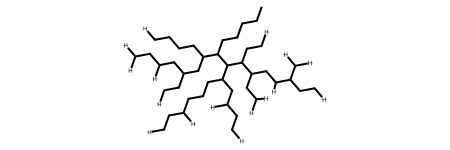

In [36]:
generative_bigSMILES = "C{[>][<]CC[>],[<]CC([>])[>],[<]C([>])C([>])[>];[<][H][]}|gauss(5e2,1e1)|"
draw_molecule(generative_bigSMILES)

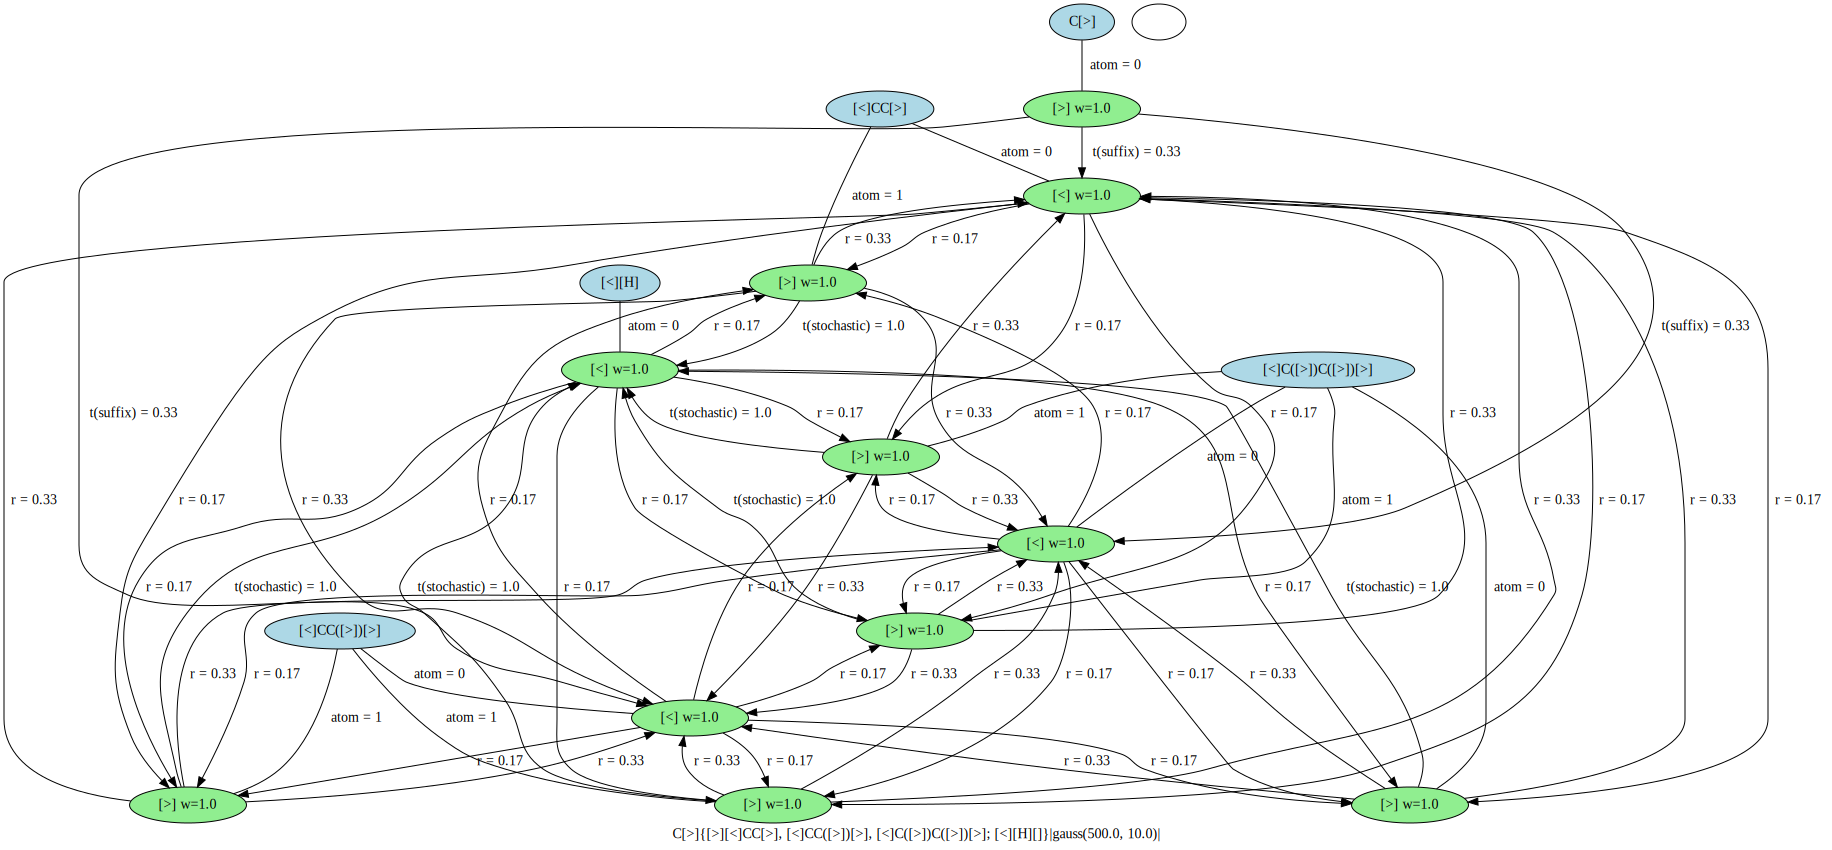

In [37]:
draw_generation_graph(generative_bigSMILES)